In [3]:
import pyspark as ps
import numpy as np
import socket
import platform
import pandas as pd
from pyspark.sql import SQLContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.sql.functions import udf, col, when
import matplotlib.pyplot as plt

In [4]:
appName = "Recommender system in Spark"
spark = ps.sql.SparkSession.builder\
            .master("local") \
            .appName("Book Recommendation Engine") \
            .getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [5]:
def get_Host_name_IP(): 
    try: 
        host_name = socket.gethostname() 
        host_ip = socket.gethostbyname(host_name) 
        print("Hostname :  ",host_name) 
        print("IP : ",host_ip) 
    except: 
        print("Unable to get Hostname and IP")
        
get_Host_name_IP()

Hostname :   DESKTOP-4CF8UEG
IP :  192.168.0.22


In [4]:
print("Computer Config")
system_conf = platform.uname()

print(f"System: {system_conf.system}")
print(f"Node Name: {system_conf.node}")
print(f"Release: {system_conf.release}")
print(f"Version: {system_conf.version}")
print(f"Machine: {system_conf.machine}")
print(f"Processor: {system_conf.processor}")

Computer Config
System: Windows
Node Name: DESKTOP-KD1TH9K
Release: 10
Version: 10.0.19041
Machine: AMD64
Processor: Intel64 Family 6 Model 94 Stepping 3, GenuineIntel


In [6]:
ratings = spark.read.csv(r"C:\Users\Nilayy\Desktop\dataset\ratings.csv", header=True, inferSchema=True) 
ratings.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [6]:
ratings.show(10)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
|      1|   2077|     4|
|      1|   2487|     4|
|      1|   2900|     5|
|      1|   3662|     4|
|      1|   3922|     5|
+-------+-------+------+
only showing top 10 rows



In [7]:
books = spark.read.csv(r"C:\Users\yonca\Desktop\Final_BüyükVeri\dataset\books.csv", header=True, inferSchema=True) 
books.printSchema()

root
 |-- id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- work_ratings_count: string (nullable = true)
 |-- work_text_reviews_count: string (nullable = true)
 |-- ratings_1: double (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nullable = true)


In [8]:
books.show(5)

+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------+--------------------+
| id|book_id|best_book_id|work_id|books_count|     isbn|          isbn13|             authors|original_publication_year|      original_title|               title|language_code|average_rating|ratings_count|work_ratings_count|work_text_reviews_count|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|           image_url|     small_image_url|
+---+-------+------------+-------+-----------+---------+----------------+--------------------+-------------------------+--------------------+--------------------+-------------+--------------+-------------+------------------+-----------------------+---------+---------+---------+---------+---------+--------------------

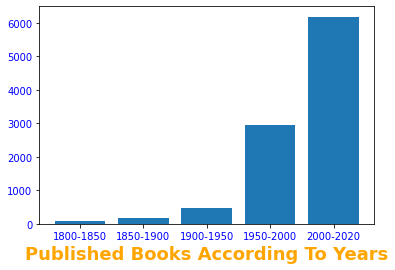

Text(0.5, 0, 'Published Books According To Years')

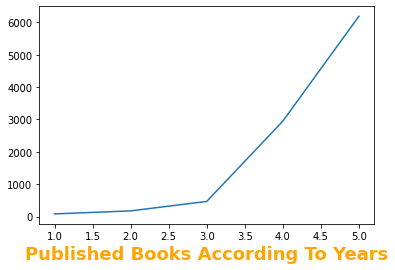

In [9]:
#print(books.toPandas()['original_publication_year'].unique().shape)
books_pandas = books.toPandas()
l1_count = books_pandas[(books_pandas['original_publication_year'] >= 1800) & (books_pandas['original_publication_year'] < 1850)]
l2_count = books_pandas[(books_pandas['original_publication_year'] >= 1850) & (books_pandas['original_publication_year'] < 1900)]
l3_count = books_pandas[(books_pandas['original_publication_year'] >= 1900) & (books_pandas['original_publication_year'] < 1950)]
l4_count = books_pandas[(books_pandas['original_publication_year'] >= 1950) & (books_pandas['original_publication_year'] < 2000)]
l5_count = books_pandas[(books_pandas['original_publication_year'] >= 2000) & (books_pandas['original_publication_year'] < 2020)]

height = [l1_count.shape[0], l2_count.shape[0], l3_count.shape[0], l4_count.shape[0], l5_count.shape[0]]
 
bars = ('1800-1850', '1850-1900', '1900-1950', '1950-2000', '2000-2020')
y_pos = np.arange(len(bars))
 
plt.bar(y_pos, height)
 
plt.xticks(y_pos, bars, color='blue')
plt.yticks(color='blue')
plt.xlabel('Published Books According To Years', fontweight='bold', color = 'orange', fontsize='18')

plt.show()

# print line plot.
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot([1, 2, 3, 4, 5], [l1_count.shape[0], l2_count.shape[0], l3_count.shape[0], l4_count.shape[0], l5_count.shape[0]])  # Plot some data on the axes.
plt.xlabel('Published Books According To Years', fontweight='bold', color = 'orange', fontsize='18')



In [10]:
training, validation = ratings.randomSplit([.7,.3])

In [12]:
als =ALS(maxIter=5,regParam=0.01, rank=10, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =4.480201530281656


In [13]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 3.2291517|
|    148|  24326|     5| 3.2135563|
|    148|  10140|     3| 2.5370867|
|    148|  13991|     4| 4.1649113|
|    148|  10610|     4| 3.7679412|
|    148|  11569|     2| 3.5470116|
|    148|   8440|     3| 3.3266873|
|    148|  29031|     3| 4.4091973|
|    148|   8510|     3|  3.747941|
|    148|   2171|     4| 3.4893057|
+-------+-------+------+----------+
only showing top 10 rows



In [14]:
pred_arr = predictions.toPandas()

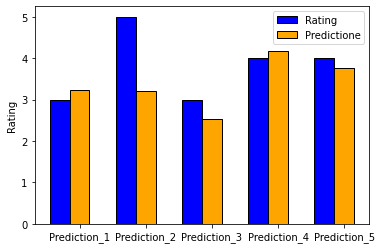

In [15]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [16]:
als =ALS(maxIter=5,regParam=0.1, rank=10, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =1.0793906265216076


In [17]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 2.9676414|
|    148|  24326|     5| 3.3267012|
|    148|  10140|     3| 2.7818825|
|    148|  13991|     4| 3.8236709|
|    148|  10610|     4| 3.8420846|
|    148|  11569|     2| 3.4530537|
|    148|   8440|     3| 3.1907957|
|    148|  29031|     3| 3.5798583|
|    148|   8510|     3|  3.345409|
|    148|   2171|     4| 3.4328349|
+-------+-------+------+----------+
only showing top 10 rows



In [18]:
pred_arr = predictions.toPandas()

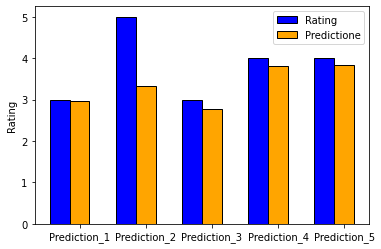

In [19]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [20]:
als =ALS(maxIter=5,regParam=0.01, rank=50, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =1.9455661260030832


In [21]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 3.1267052|
|    148|  24326|     5| 2.1658254|
|    148|  10140|     3| 4.3616776|
|    148|  13991|     4|   4.07409|
|    148|  10610|     4| 2.0680456|
|    148|  11569|     2|  4.736159|
|    148|   8440|     3| 3.0810251|
|    148|  29031|     3| 2.6255922|
|    148|   8510|     3|  2.687926|
|    148|   2171|     4| 2.3664396|
+-------+-------+------+----------+
only showing top 10 rows



In [22]:
pred_arr = predictions.toPandas()

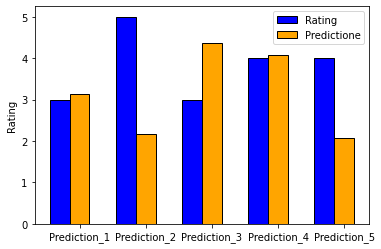

In [23]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [24]:
als =ALS(maxIter=5,regParam=0.1, rank=50, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.9963975142586904


In [25]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3|  3.032034|
|    148|  24326|     5| 3.2456317|
|    148|  10140|     3| 2.7692778|
|    148|  13991|     4| 3.7267506|
|    148|  10610|     4|  3.841927|
|    148|  11569|     2| 3.7030916|
|    148|   8440|     3|  2.879486|
|    148|  29031|     3| 3.1381044|
|    148|   8510|     3|   3.05894|
|    148|   2171|     4|  3.445322|
+-------+-------+------+----------+
only showing top 10 rows



In [26]:
pred_arr = predictions.toPandas()

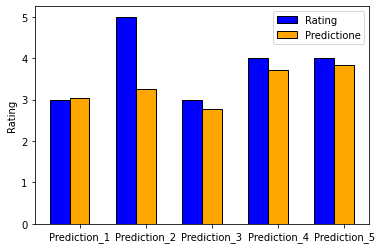

In [27]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [28]:
als =ALS(maxIter=5,regParam=0.01, rank=100, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =1.1626380520284787


In [29]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 3.4589443|
|    148|  24326|     5| 2.7614129|
|    148|  10140|     3| 2.4347498|
|    148|  13991|     4|  3.047411|
|    148|  10610|     4| 3.7056844|
|    148|  11569|     2| 3.3756704|
|    148|   8440|     3| 3.3470623|
|    148|  29031|     3|   4.27324|
|    148|   8510|     3| 2.8204308|
|    148|   2171|     4| 3.3916056|
+-------+-------+------+----------+
only showing top 10 rows



In [30]:
pred_arr = predictions.toPandas()

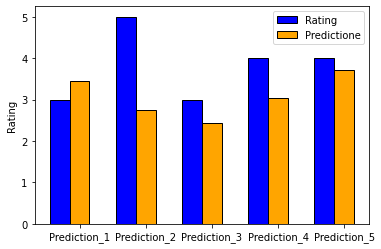

In [31]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [32]:
als =ALS(maxIter=5,regParam=0.1, rank=100, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.9518198686174815


In [33]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 2.9504406|
|    148|  24326|     5|  3.410782|
|    148|  10140|     3| 2.7679646|
|    148|  13991|     4| 3.5759444|
|    148|  10610|     4| 3.7860143|
|    148|  11569|     2| 3.5894527|
|    148|   8440|     3| 3.0692854|
|    148|  29031|     3| 3.4267032|
|    148|   8510|     3|  3.146552|
|    148|   2171|     4|  3.346509|
+-------+-------+------+----------+
only showing top 10 rows



In [34]:
pred_arr = predictions.toPandas()

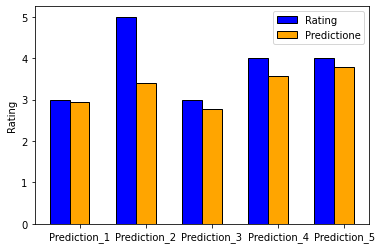

In [35]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [36]:
als =ALS(maxIter=10,regParam=0.01, rank=10, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =2.2740100940270804


In [37]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 3.3719528|
|    148|  24326|     5|  3.210324|
|    148|  10140|     3| 2.3789272|
|    148|  13991|     4|  4.167864|
|    148|  10610|     4| 3.8329117|
|    148|  11569|     2| 3.3879528|
|    148|   8440|     3| 3.1847758|
|    148|  29031|     3| 4.1641073|
|    148|   8510|     3| 3.3390865|
|    148|   2171|     4| 3.6995943|
+-------+-------+------+----------+
only showing top 10 rows



In [38]:
pred_arr = predictions.toPandas()

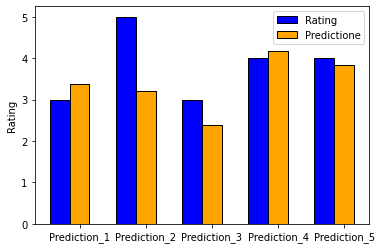

In [39]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [40]:
als =ALS(maxIter=10,regParam=0.1, rank=10, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='rmse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Root Mean Squared Error =" + str(mse))

Root Mean Squared Error =0.9231085241034463


In [41]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 2.9242492|
|    148|  24326|     5|  3.272995|
|    148|  10140|     3| 2.7671998|
|    148|  13991|     4|  3.745944|
|    148|  10610|     4| 3.8309107|
|    148|  11569|     2|  3.414052|
|    148|   8440|     3| 3.0545058|
|    148|  29031|     3| 3.4554827|
|    148|   8510|     3| 3.0883625|
|    148|   2171|     4| 3.4522903|
+-------+-------+------+----------+
only showing top 10 rows



In [42]:
pred_arr = predictions.toPandas()

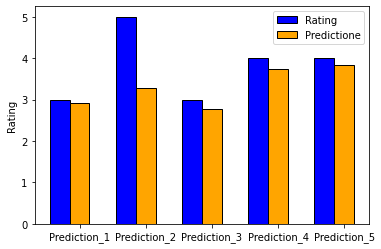

In [43]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [44]:
als =ALS(maxIter=10,regParam=0.01, rank=50, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =1.1454975255110746


In [45]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 3.4244714|
|    148|  24326|     5|  2.005247|
|    148|  10140|     3| 3.8131108|
|    148|  13991|     4| 4.1824036|
|    148|  10610|     4| 3.0956328|
|    148|  11569|     2|  4.064213|
|    148|   8440|     3|  2.944862|
|    148|  29031|     3| 2.3370435|
|    148|   8510|     3| 2.5873866|
|    148|   2171|     4| 2.4490469|
+-------+-------+------+----------+
only showing top 10 rows



In [46]:
pred_arr = predictions.toPandas()

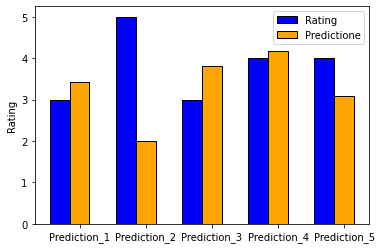

In [47]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [48]:
als =ALS(maxIter=10,regParam=0.1, rank=50, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.8075795661455852


In [49]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 2.9818723|
|    148|  24326|     5| 3.1046405|
|    148|  10140|     3| 2.7416606|
|    148|  13991|     4| 3.6862955|
|    148|  10610|     4|  3.730769|
|    148|  11569|     2| 3.6864507|
|    148|   8440|     3| 2.9883876|
|    148|  29031|     3|  3.215085|
|    148|   8510|     3|  2.799493|
|    148|   2171|     4| 3.3230727|
+-------+-------+------+----------+
only showing top 10 rows



In [50]:
pred_arr = predictions.toPandas()

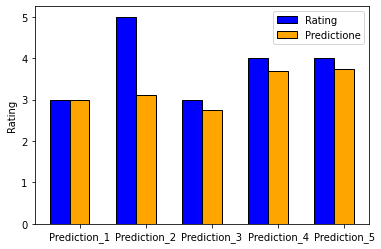

In [51]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [52]:
als =ALS(maxIter=10,regParam=0.01, rank=100, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.9126663107030001


In [53]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 2.9091399|
|    148|  24326|     5| 3.2530034|
|    148|  10140|     3|  2.502994|
|    148|  13991|     4| 3.6310444|
|    148|  10610|     4| 4.3637753|
|    148|  11569|     2| 3.2608118|
|    148|   8440|     3|  2.707437|
|    148|  29031|     3|  3.671193|
|    148|   8510|     3| 2.5655758|
|    148|   2171|     4|   2.99344|
+-------+-------+------+----------+
only showing top 10 rows



In [54]:
pred_arr = predictions.toPandas()

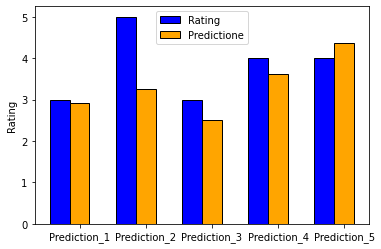

In [55]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [56]:
als =ALS(maxIter=10,regParam=0.1, rank=100, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.7935447193923424


In [57]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 2.8691196|
|    148|  24326|     5| 3.3675466|
|    148|  10140|     3|  2.785399|
|    148|  13991|     4|  3.639722|
|    148|  10610|     4|  3.713633|
|    148|  11569|     2|  3.573561|
|    148|   8440|     3| 3.0541885|
|    148|  29031|     3| 3.3195095|
|    148|   8510|     3| 3.0018785|
|    148|   2171|     4| 3.4192991|
+-------+-------+------+----------+
only showing top 10 rows



In [58]:
pred_arr = predictions.toPandas()

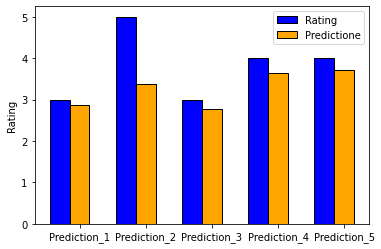

In [59]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [60]:
als =ALS(maxIter=15,regParam=0.01, rank=10, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =1.8229097617091403


In [61]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 3.3492882|
|    148|  24326|     5|  3.222043|
|    148|  10140|     3|  2.352969|
|    148|  13991|     4| 4.1921215|
|    148|  10610|     4| 3.8477328|
|    148|  11569|     2| 3.2235413|
|    148|   8440|     3| 3.0738204|
|    148|  29031|     3| 4.2043967|
|    148|   8510|     3|  3.118398|
|    148|   2171|     4|  3.773509|
+-------+-------+------+----------+
only showing top 10 rows



In [62]:
pred_arr = predictions.toPandas()

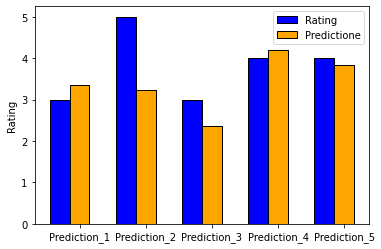

In [63]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [64]:
als =ALS(maxIter=15,regParam=0.1, rank=10, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.8378813990851887


In [65]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3|  2.947927|
|    148|  24326|     5| 3.2313454|
|    148|  10140|     3|  2.736107|
|    148|  13991|     4| 3.7575326|
|    148|  10610|     4| 3.8585951|
|    148|  11569|     2|  3.467792|
|    148|   8440|     3| 3.0980027|
|    148|  29031|     3| 3.4051833|
|    148|   8510|     3|  2.909329|
|    148|   2171|     4|  3.409178|
+-------+-------+------+----------+
only showing top 10 rows



In [66]:
pred_arr = predictions.toPandas()

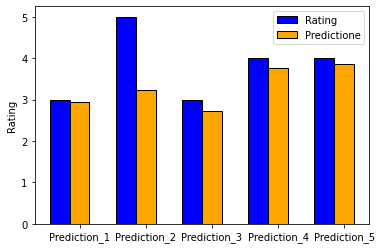

In [67]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [68]:
als =ALS(maxIter=15,regParam=0.01, rank=50, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =1.0098019067999742


In [69]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3|  3.734938|
|    148|  24326|     5| 1.9356412|
|    148|  10140|     3| 3.4691603|
|    148|  13991|     4|  4.330987|
|    148|  10610|     4|  3.619579|
|    148|  11569|     2| 3.7257771|
|    148|   8440|     3| 2.9929984|
|    148|  29031|     3| 2.4262798|
|    148|   8510|     3| 2.7059934|
|    148|   2171|     4| 2.8103175|
+-------+-------+------+----------+
only showing top 10 rows



In [70]:
pred_arr = predictions.toPandas()

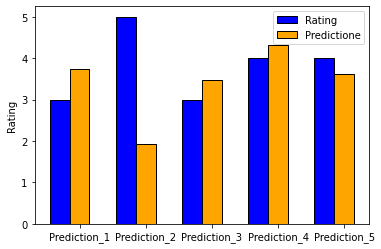

In [71]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [72]:
als =ALS(maxIter=15,regParam=0.1, rank=50, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.7925187484233024


In [73]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3| 2.9452684|
|    148|  24326|     5|  3.084248|
|    148|  10140|     3| 2.7516904|
|    148|  13991|     4| 3.6678934|
|    148|  10610|     4| 3.6719153|
|    148|  11569|     2| 3.6520538|
|    148|   8440|     3| 2.9907384|
|    148|  29031|     3| 3.2285612|
|    148|   8510|     3| 2.7130141|
|    148|   2171|     4| 3.2887998|
+-------+-------+------+----------+
only showing top 10 rows



In [74]:
pred_arr = predictions.toPandas()

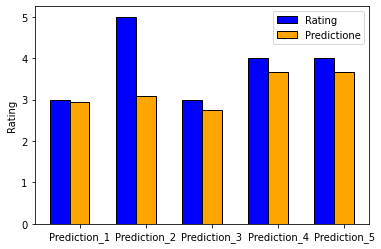

In [75]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [76]:
als =ALS(maxIter=15,regParam=0.01, rank=100, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.8700636231563605


In [77]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3|  2.999775|
|    148|  24326|     5| 3.4364967|
|    148|  10140|     3| 2.5697331|
|    148|  13991|     4| 3.6858537|
|    148|  10610|     4| 4.2121053|
|    148|  11569|     2| 3.3501303|
|    148|   8440|     3| 2.7785814|
|    148|  29031|     3| 3.5694928|
|    148|   8510|     3| 2.7600124|
|    148|   2171|     4| 2.8715677|
+-------+-------+------+----------+
only showing top 10 rows



In [78]:
pred_arr = predictions.toPandas()

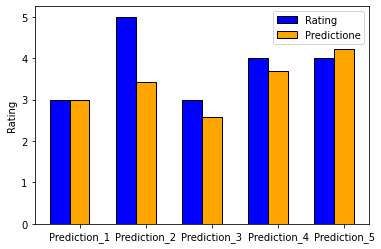

In [79]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [80]:
als =ALS(maxIter=15,regParam=0.1, rank=100, seed=5033, userCol="user_id", itemCol="book_id", ratingCol="rating")
model = als.fit(training)
predictions= model.transform(validation)
new_predictions=predictions.filter(col('prediction') != np.nan)
evaluator = RegressionEvaluator(metricName='mse',labelCol="rating",predictionCol="prediction")
mse = evaluator.evaluate(new_predictions)
print("Mean Squared Error =" + str(mse))

Mean Squared Error =0.7808862409919661


In [81]:
predictions = model.transform(validation)
predictions.show(n=10)

+-------+-------+------+----------+
|book_id|user_id|rating|prediction|
+-------+-------+------+----------+
|    148|   9731|     3|  2.851392|
|    148|  24326|     5| 3.3352554|
|    148|  10140|     3| 2.7846553|
|    148|  13991|     4| 3.6586177|
|    148|  10610|     4| 3.7049656|
|    148|  11569|     2| 3.5707653|
|    148|   8440|     3| 3.0381887|
|    148|  29031|     3|  3.328506|
|    148|   8510|     3|  2.973256|
|    148|   2171|     4| 3.4758306|
+-------+-------+------+----------+
only showing top 10 rows



In [82]:
pred_arr = predictions.toPandas()

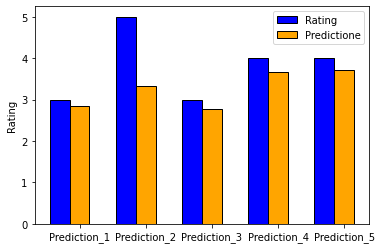

In [83]:
bars1 = []
bars2 = []

for i in range(5):
    bars1.append(pred_arr['rating'][i])
    bars2.append(pred_arr['prediction'][i])

barWidth = 0.3
 
yer1 = [0.5, 0.4, 0.5]
yer2 = [1, 0.7, 1]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', capsize=7, label='Rating')
plt.bar(r2, bars2, width = barWidth, color = 'orange', edgecolor = 'black', capsize=7, label='Predictione')
 
plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
plt.ylabel('Rating')
plt.legend()
 
plt.show()

In [84]:
predictions.join(books, "book_id").select("user_id","title","prediction").show(5)

+-------+----------+----------+
|user_id|     title|prediction|
+-------+----------+----------+
|  35982|Lysistrata| 3.7992926|
|  12014|Lysistrata| 3.9062772|
|  11326|Lysistrata| 4.0836697|
|  12761|Lysistrata| 4.2158794|
|  38734|Lysistrata|  4.483857|
+-------+----------+----------+
only showing top 5 rows



In [85]:
forOneUser = predictions.filter(col("user_id")==35982).join(books,"book_id").select("user_id","title","image_url","prediction")

In [86]:
forOneUser.count()

5

In [87]:
forOneUser.show()

+-------+--------------------+--------------------+----------+
|user_id|               title|           image_url|prediction|
+-------+--------------------+--------------------+----------+
|  35982|          Lysistrata|https://images.gr...| 3.7992926|
|  35982|              Anthem|https://s.gr-asse...| 2.0331638|
|  35982|Another Bullshit ...|https://s.gr-asse...|  3.631935|
|  35982|City of Glass (Th...|https://images.gr...| 3.6882682|
|  35982|The Iliad/The Ody...|https://s.gr-asse...| 2.7727218|
+-------+--------------------+--------------------+----------+



In [91]:
from IPython.display import display
from IPython.display import Image
for book in forOneUser.take(10):
    print(book.title)
    display(Image(url=book.image_url))

Lysistrata


Anthem


Another Bullshit Night in Suck City


City of Glass (The New York Trilogy, #1)


The Iliad/The Odyssey


In [92]:
#Generate top 5 books recommendations for each user
userRecomments = model.recommendForAllUsers(5)
#Generate top 5 user recommendations for each book
bookRecomments = model.recommendForAllItems(5)

In [93]:
userRecomments.select("user_id","recommendations.book_id").show(10,False)

+-------+------------------------------+
|user_id|book_id                       |
+-------+------------------------------+
|148    |[9842, 8926, 8548, 9076, 7305]|
|463    |[2975, 5388, 7325, 9114, 3395]|
|471    |[7438, 862, 1029, 3321, 4674] |
|496    |[6902, 8897, 9842, 8521, 4778]|
|833    |[8548, 5207, 8516, 5754, 9842]|
|1088   |[3628, 1380, 2353, 3472, 1788]|
|1238   |[7399, 928, 8548, 985, 721]   |
|1342   |[7401, 4868, 3817, 1788, 5627]|
|1580   |[6590, 6920, 8109, 1265, 8187]|
|1591   |[8866, 3753, 3241, 7902, 3345]|
+-------+------------------------------+
only showing top 10 rows



In [94]:
userRecomments.printSchema()

root
 |-- user_id: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- book_id: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [95]:
bookRecomments.select("book_id","recommendations.user_id").show(10,False)

+-------+-----------------------------------+
|book_id|user_id                            |
+-------+-----------------------------------+
|1580   |[13006, 46421, 7120, 44637, 22313] |
|4900   |[52028, 20914, 45943, 38867, 36452]|
|5300   |[50889, 32039, 48009, 40992, 33982]|
|6620   |[40439, 20597, 28066, 22111, 44637]|
|7240   |[40439, 4134, 52028, 36452, 52469] |
|7340   |[33099, 12912, 50291, 36452, 52028]|
|7880   |[28777, 8403, 10340, 39714, 28975] |
|9900   |[6240, 38866, 35102, 40439, 50209] |
|471    |[12912, 22313, 13006, 18102, 4134] |
|1591   |[13006, 21947, 50291, 42125, 31925]|
+-------+-----------------------------------+
only showing top 10 rows



In [96]:
#Generate top 10 book recommendations for a specified set of users
users = ratings.select("user_id").distinct().limit(3);
users.show()

+-------+
|user_id|
+-------+
|  32592|
|  19984|
|  35982|
+-------+



In [97]:
userSubsetRecs = model.recommendForUserSubset(users,10)

In [98]:
userSubsetRecs.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|  32592|[[3753, 4.8878], ...|
|  35982|[[983, 4.668975],...|
|  19984|[[3753, 5.9829097...|
+-------+--------------------+



In [99]:
userSubsetRecs.select("user_id","recommendations.book_id").show(10,False)

+-------+------------------------------------------------------------+
|user_id|book_id                                                     |
+-------+------------------------------------------------------------+
|32592  |[3753, 9076, 1597, 6902, 1308, 862, 1274, 2101, 3628, 4868] |
|35982  |[983, 5580, 5207, 7254, 3628, 7593, 1788, 6590, 2869, 6361] |
|19984  |[3753, 9076, 6902, 9842, 8548, 3628, 6920, 3491, 1618, 1010]|
+-------+------------------------------------------------------------+



In [100]:
#Generate top 10 user recommendations for a specified set of books
book1 = ratings.select("book_id").distinct().limit(3)
book1.show()

+-------+
|book_id|
+-------+
|    148|
|    463|
|    471|
+-------+



In [102]:
bookSubSetRecs = model.recommendForItemSubset(book1, 10)
bookSubSetRecs.select("book_id","recommendations.user_id").show(10,False)

+-------+----------------------------------------------------------------------+
|book_id|user_id                                                               |
+-------+----------------------------------------------------------------------+
|471    |[12912, 22313, 13006, 18102, 4134, 30184, 19941, 24073, 33099, 33969] |
|463    |[22313, 44191, 49830, 41421, 19137, 52469, 42125, 22186, 39979, 30653]|
|148    |[22313, 11193, 13006, 33969, 7868, 46421, 8643, 19984, 32996, 23487]  |
+-------+----------------------------------------------------------------------+



In [103]:
#Prediction for a user and match with to-read list
book_ids = [860,1524,2885,2914,5297,7397,8802,9506]
user_ids = [4917,4917,4917,4917,4917,4917,4917,4917]
new_user_preds = sqlContext.createDataFrame(zip(book_ids,user_ids), schema = ['book_id','user_id'])

In [104]:
new_user_preds.show()

+-------+-------+
|book_id|user_id|
+-------+-------+
|    860|   4917|
|   1524|   4917|
|   2885|   4917|
|   2914|   4917|
|   5297|   4917|
|   7397|   4917|
|   8802|   4917|
|   9506|   4917|
+-------+-------+



In [105]:
new_predictions = model.transform(new_user_preds)
new_predictions.show()

+-------+-------+----------+
|book_id|user_id|prediction|
+-------+-------+----------+
|   2914|   4917| 2.8714437|
|    860|   4917| 3.5368922|
|   2885|   4917|  3.168972|
|   7397|   4917| 3.0444274|
|   8802|   4917| 3.2045946|
|   9506|   4917|  3.124133|
|   1524|   4917| 3.6029627|
|   5297|   4917|  3.391838|
+-------+-------+----------+

